<div style="font-size:200%; font-weight:bold; font-variant:small-caps;">Topic Modeling Clustering</div>

In this notebook we visualize a previously generated topic model.

# Set Up

## Imports

In [1]:
import pandas as pd
import numpy as np
from lib import tapi

## Configuration

In [2]:
tapi.list_dbs()

/Users/rca2t1/Dropbox/Courses/NEH/TAPI_Topic_Models


['jstor_hyperparameter_demo', 'tamilnet', 'winereviews']

In [3]:
data_prefix = 'winereviews'
# data_prefix = 'jstor_hyperparameter_demo'
# data_prefix = 'tamilnet'

In [4]:
group_col = 'doc_points' # winereviews
# group_col = 'doc_year' # jstor_hyperparameter
# group_col = 'doc_label' # tamilnet

In [5]:
db = tapi.Edition(data_prefix)

## Import Topic Data

We import our previously generated model.

In [6]:
db.get_tables()

LABELS
VOCAB
BOW
TOPICS
DTM
THETA
PHI
TOPICS_NMF
THETA_NMF
PHI_NMF


## Group Topics by Label

In [7]:
db.LABELS.columns

Index(['doc_variety', 'doc_place', 'doc_label', 'doc_province', 'doc_title',
       'doc_price', 'doc_points', 'doc_taster'],
      dtype='object')

In [8]:
group_vals = db.LABELS[group_col].value_counts().to_frame('n')
group_vals.index.name = 'group_id'

### Frequency by Group

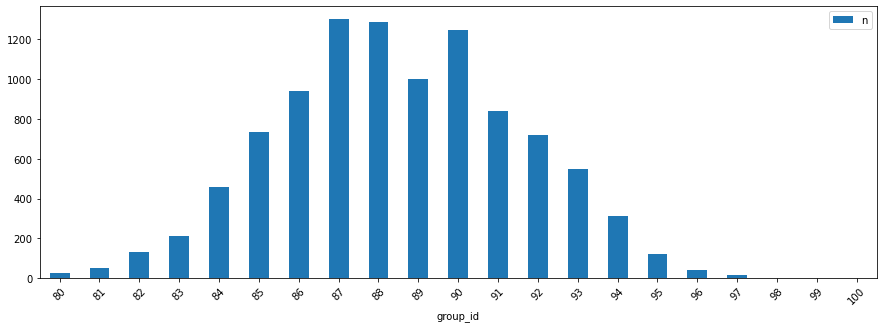

In [9]:
group_vals.sort_index().plot.bar(rot=45, figsize=(15,5));

### Collapse THETA Tables

In [10]:
G = db.THETA.join(db.LABELS).groupby(group_col)[db.topic_cols].mean()
G.index.name = 'group_id'
G.columns = db.TOPICS.topwords

In [11]:
G2 = db.THETA_NMF.join(db.LABELS).groupby(group_col)[db.topic_cols].mean()
G2.index.name = 'group_id'
G2.columns = db.TOPICS_NMF.topwords

### Heatmap of Labels and Topics

In [12]:
# G.style.background_gradient(cmap='YlGnBu', axis=0)

In [13]:
# G.style.background_gradient(cmap='YlGnBu', axis=1)

In [14]:
# G2.style.background_gradient(cmap='YlGnBu', axis=0)

In [15]:
# G2.style.background_gradient(cmap='YlGnBu', axis=1)

### Top Topic per Label Group

In [16]:
group_vals['top_topic'] = G.T[group_vals.index].idxmax()
group_vals['top_topic2'] = G2.T[group_vals.index].idxmax()

In [17]:
# group_vals.sort_values('top_topic')

### Top Label Group per Topic

In [18]:
# G.idxmax().to_frame('label').sort_values('label')

In [19]:
# G2.idxmax().to_frame('label').sort_values('label')

## How Similar are the Topics to Each Other?

Get the dot product of the two topic series over documents.

### Dot Product

In [20]:
X = db.THETA.T.dot(db.THETA_NMF)
X.columns = db.TOPICS_NMF.topwords
X.index = db.TOPICS.topwords
X.columns.name = 'NMF'
X.index.name = 'LDA'

In [21]:
Y = db.PHI.dot(db.PHI_NMF.T)
Y.columns = db.TOPICS_NMF.topwords
Y.index = db.TOPICS.topwords
Y.columns.name = 'NMF'
Y.index.name = 'LDA'

In [22]:
# X

In [23]:
X2 = X.stack().to_frame('w').sort_values('w', ascending=False)

In [24]:
Y2 = Y.stack().to_frame('w').sort_values('w', ascending=False)

In [25]:
X2.head(10).style.bar()

In [26]:
Y2.head(10).style.bar()

<AxesSubplot:>

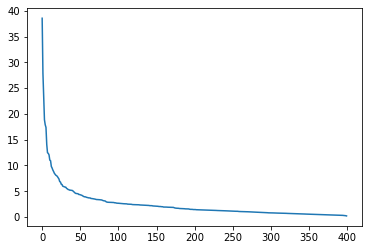

In [27]:
X2['w'].reset_index()['w'].plot()

<AxesSubplot:>

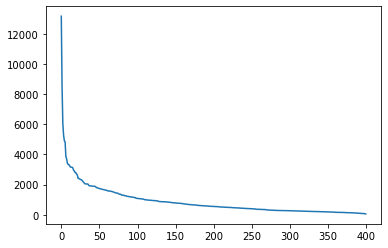

In [28]:
Y2['w'].reset_index()['w'].plot()

## Bigraph Visualization 

Createa a bigraph of the LDA and NMF topics based on their co-occurrence as top topics for a given group. 

In [29]:
import pydot
from IPython.display import SVG, display

### By Group Co-occurrence

In [30]:
group_vals['t1'] = group_vals.top_topic.str.extract(r"^(\d+):?\s").astype('int')
group_vals['t2'] = group_vals.top_topic2.str.extract(r"^(\d+):?\s").astype('int')

In [31]:
db.TOPICS['type'] = 'LDA'
db.TOPICS_NMF['type'] = 'NMF'

In [32]:
E = group_vals.groupby(['t1', 't2']).n.sum().to_frame()

In [33]:
used_nodes = {'LDA': set(E.reset_index().t1), 
              'NMF': set(E.reset_index().t2)}

In [34]:
used_nodes

{'LDA': {3, 18, 19}, 'NMF': {0, 1, 3, 4, 6, 9, 13}}

In [35]:
graph = pydot.Dot('topic_graph', graph_type='graph', rankdir="LR")

def add_edge(x):
    global graph    
    t1_id = 'LDA' + str(x.t1)
    t2_id = 'NMF' + str(x.t2)
    graph.add_edge(pydot.Edge(t1_id, t2_id,
        label=x.n, 
        color='lightgray', 
        fontsize=10, 
        penwidth=np.log2(x.n),
        fontcolor='green',
        fontname='Arial')) 

_ = E.reset_index().apply(add_edge, 1)

def add_node(x):
    global graph
    node_id = x.type + str(x.name)
    node_label = x.type + " " + x.topwords.replace(", ", "\n")
    graph.add_node(pydot.Node(node_id, 
        label=node_label,
        shape='plain',
        fontname='Arial'))

_ = db.TOPICS.loc[used_nodes['LDA']].apply(add_node, 1)
_ = db.TOPICS_NMF.loc[used_nodes['NMF']].apply(add_node, 1)

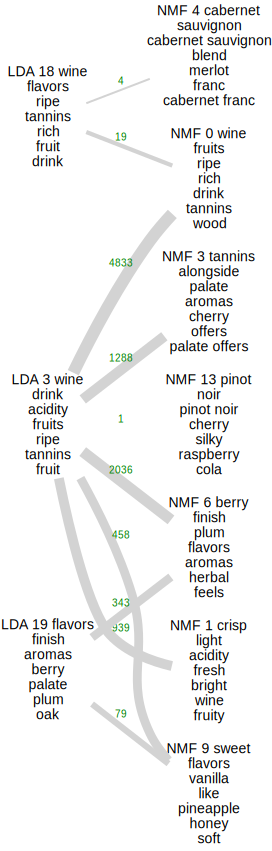

In [36]:
display(SVG(graph.create_svg()))

<AxesSubplot:xlabel='t1,t2'>

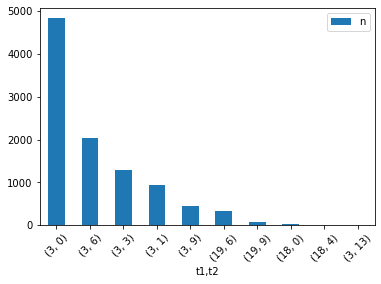

In [37]:
E.sort_values('n', ascending=False).plot.bar(rot=45)

### By Dot Product

In [38]:
X3 = X2.reset_index()
X3['t1'] = X3.LDA.str.extract("^(\d+)")
X3['t2'] = X3.NMF.str.extract("^(\d+)")
X3 = X3.groupby(['t1','t2']).w.sum().to_frame('w_sum').reset_index()

In [39]:
X3.sort_values('w_sum', ascending=False)

,t1,t2,w_sum
260,3,0,38.573347
333,6,3,27.892149
236,19,6,23.284240
261,3,1,18.868995
270,3,18,17.895993
...,...,...,...
250,2,18,0.296998
86,12,14,0.291066
85,12,13,0.260145
92,12,2,0.241800


<AxesSubplot:>

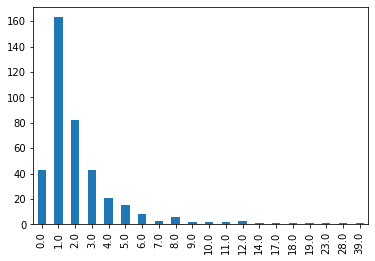

In [40]:
X3.w_sum.round().value_counts().sort_index().plot.bar()

# Create network based on dot products